# BERT Fine-Tuning

Binary sentiment classification using `bert-base-uncased` fine-tuned with HuggingFace Trainer.

Prerequisite: run `00_preprocessing.ipynb` first.

In [1]:
import warnings
import os
import logging

# Must be set BEFORE any transformers/torch import
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "1"
os.environ["TRANSFORMERS_VERBOSITY"] = "error"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"
os.environ["HF_HUB_DISABLE_IMPLICIT_TOKEN"] = "1"

warnings.filterwarnings("ignore")
logging.disable(logging.WARNING)

import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns

# Re-enable logging for training progress only
logging.disable(logging.NOTSET)
logging.getLogger("transformers").setLevel(logging.ERROR)
logging.getLogger("torch").setLevel(logging.ERROR)
logging.getLogger("accelerate").setLevel(logging.ERROR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


## Load data and split

In [2]:
df = pd.read_csv('../data/reviews_extraidas.csv')
df['label'] = (df['Y'] > 5).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    df['X'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 435, Test: 109


## Prepare datasets

In [3]:
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            str(self.texts.iloc[idx]),
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels.iloc[idx], dtype=torch.long),
        }

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = ReviewDataset(X_train, y_train, tokenizer)
test_dataset = ReviewDataset(X_test, y_test, tokenizer)

print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")

Train: 435, Test: 109


## Fine-tune BERT

In [4]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds, average='weighted'),
    }

training_args = TrainingArguments(
    output_dir='/tmp/bert_checkpoints',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_steps=10,
    eval_strategy='epoch',
    save_strategy='no',
    dataloader_pin_memory=False,
    disable_tqdm=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.688533,0.658009,0.577982,0.576987
2,0.428255,0.431320,0.788991,0.791949
3,0.176295,0.634820,0.798165,0.800388


TrainOutput(global_step=165, training_loss=0.46545483126784815, metrics={'train_runtime': 77.5494, 'train_samples_per_second': 16.828, 'train_steps_per_second': 2.128, 'total_flos': 171679963622400.0, 'train_loss': 0.46545483126784815, 'epoch': 3.0})

## Evaluation

In [5]:
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(-1)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 (macro): {f1_score(y_test, y_pred, average='macro'):.4f}")
print(f"F1 (weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")
print()
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

Accuracy: 0.7982
F1 (macro): 0.7904
F1 (weighted): 0.8004

              precision    recall  f1-score   support

    Negative       0.87      0.79      0.83        68
    Positive       0.70      0.80      0.75        41

    accuracy                           0.80       109
   macro avg       0.79      0.80      0.79       109
weighted avg       0.81      0.80      0.80       109



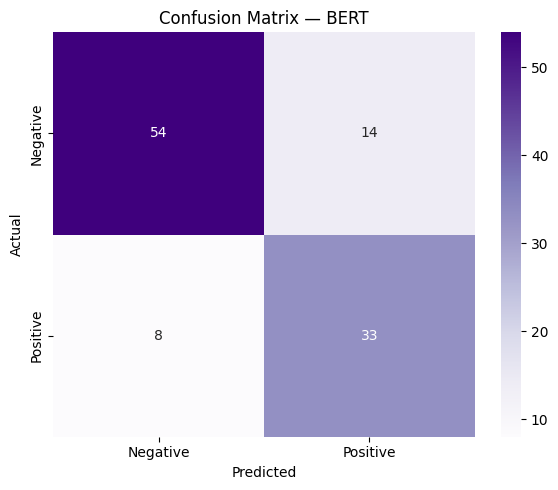

In [6]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix — BERT')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## Inference on new reviews

In [7]:
samples = [
    "This movie was absolutely amazing! I loved every moment of it.",
    "Terrible film. Waste of time and money. Do not watch.",
    "It was okay, nothing special but not bad either.",
]

label_map = {0: 'Negative', 1: 'Positive'}
model_cpu = model.cpu()
model_cpu.eval()

for text in samples:
    inputs = tokenizer(text, truncation=True, padding='max_length', max_length=256, return_tensors='pt')

    with torch.no_grad():
        logits = model_cpu(**inputs).logits
        probs = torch.softmax(logits, dim=1)[0]
        pred = logits.argmax(dim=1).item()

    print(f"{label_map[pred]:>8s} ({probs[pred]:.2%})  |  {text}")

Positive (96.16%)  |  This movie was absolutely amazing! I loved every moment of it.
Negative (99.06%)  |  Terrible film. Waste of time and money. Do not watch.
Positive (84.27%)  |  It was okay, nothing special but not bad either.
